In [8]:
! pip install matplotlib

     |████████████████████████████████| 9.2 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 59.4 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 67.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 73.4 MB/s eta 0:00:01


In [183]:
import torch
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [10]:
train_data = pd.read_csv("../dataset/train/train.csv")
test_data = pd.read_csv("../dataset/test/test_data.csv")

# 1. 훑어 보기

## 1-1. 훑어 보기

In [11]:
train_data.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


In [13]:
test_data.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,"{'word': 'MBC', 'start_idx': 7, 'end_idx': 9, ...","{'word': '탐사기획 스트레이트', 'start_idx': 12, 'end_i...",100,wikitree
1,1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,"{'word': '프린세스 프링', 'start_idx': 7, 'end_idx':...","{'word': '공주', 'start_idx': 84, 'end_idx': 85,...",100,wikipedia
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...","{'word': '경찰', 'start_idx': 121, 'end_idx': 12...","{'word': '1995년', 'start_idx': 31, 'end_idx': ...",100,wikipedia
3,3,정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하...,"{'word': '세조', 'start_idx': 78, 'end_idx': 79,...","{'word': '정창손', 'start_idx': 0, 'end_idx': 2, ...",100,wikipedia
4,4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...","{'word': '민주당', 'start_idx': 3, 'end_idx': 5, ...","{'word': '권영진', 'start_idx': 16, 'end_idx': 18...",100,wikitree


In [169]:
print(f"학습 데이터 개수: {len(train_data)}")
print(f"평가 데이터 개수: {len(test_data)}")

학습 데이터 개수: 32470
평가 데이터 개수: 7765


## 1-2. Null 살펴보기

In [15]:
# 학습 데이터 null -> 없음
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32470 entries, 0 to 32469
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              32470 non-null  int64 
 1   sentence        32470 non-null  object
 2   subject_entity  32470 non-null  object
 3   object_entity   32470 non-null  object
 4   label           32470 non-null  object
 5   source          32470 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [168]:
# 평가 데이터 null -> 없음
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7765 entries, 0 to 7764
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7765 non-null   int64 
 1   sentence        7765 non-null   object
 2   subject_entity  7765 non-null   object
 3   object_entity   7765 non-null   object
 4   label           7765 non-null   int64 
 5   source          7765 non-null   object
dtypes: int64(2), object(4)
memory usage: 364.1+ KB


## 1-3. label 살펴보기 

micro F1 score -> no_relation 을 제외한 샘플이 가장 많은 클래스에 가장 많은 가중치를 부여한다.

In [182]:
# label 의 개수
print(f"학습 데이터의 label 개수: {len(train_data['label'].unique())}")
print(f"평가 데이터의 label : 100 으로 임의 표현")

학습 데이터의 label 개수: 30
평가 데이터의 label : 100 으로 임의 표현


In [177]:
train_data['label'].value_counts()

label
no_relation                            9534
org:top_members/employees              4284
per:employee_of                        3573
per:title                              2103
org:member_of                          1866
org:alternate_names                    1320
per:origin                             1234
org:place_of_headquarters              1195
per:date_of_birth                      1130
per:alternate_names                    1001
per:spouse                              795
per:colleagues                          534
per:parents                             520
org:founded                             450
org:members                             420
per:date_of_death                       418
org:product                             380
per:children                            304
per:place_of_residence                  193
per:other_family                        190
per:place_of_birth                      166
org:founded_by                          155
per:product               

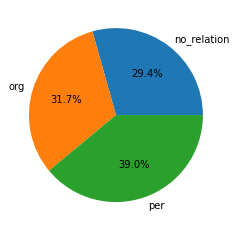

In [180]:
labels = {'no_relation': 0, 'org': 0, 'per': 0}

for label in train_data['label']:
  if label != 'no_relation':
    labels[label[:3]] += 1
  else:
    labels[label] += 1

x = np.arange(3)
plt.pie([num/32470 for num in labels.values()],labels=labels.keys(), autopct='%.1f%%')
plt.show()

## 1-4. 문장 길이 

In [195]:
min_len = float('inf')
max_len = 0
total_len = 0
lengs = []
for sentence in train_data['sentence']:
    leng = len(sentence)
    total_len += leng
    lengs.append(leng)
    
    if min_len > leng:
        min_len = leng
    if max_len < leng:
        max_len = leng
    
print(f'최소 문장 길이: {min_len}')
print(f'최대 문장 길이: {max_len}')
print(f'문장 평균 길이: {total_len/len(train_data): .1f}')

최소 문장 길이: 14
최대 문장 길이: 455
문장 평균 길이:  97.1


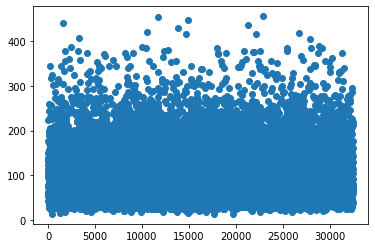

In [197]:
x_values = range(len(train_data))
plt.scatter(x_values, lengs)
plt.show()

## 1-5. 중복 데이터 확인

In [17]:
train_data.nunique()

id                32470
sentence          28803
subject_entity    26340
object_entity     25704
label                30
source                3
dtype: int64

In [18]:
test_data.nunique()

id                7765
sentence          7764
subject_entity    6758
object_entity     7162
label                1
source               3
dtype: int64

특이사항 : train dataset 의 sentence 에 중복이 존재한다.

# 2. 중복 

## 2-1. 가설 설정

중복되는 sentence 는 subject_entity, object_entity 와 label 도 동일할 것이다.

## 2-2. 가설 검증

In [41]:
def duplicated(data, subset, keep=False):
    return data.duplicated(keep=keep, subset=subset)

In [198]:
print(f'sentence 가 중복되는 데이터의 수: {sum(duplicated(train_data, ["sentence"]))}')
print(f'sentence, subject_entity 와 object_entity 가 동일한 데이터의 수: {sum(duplicated(train_data,["sentence", "subject_entity", "object_entity"]))}')
print(f'sentence, subject-entity, object_entity 와 label 이 동일한 데이터의 수: {sum(duplicated(train_data, ["sentence","subject_entity","object_entity", "label"]))}')

sentence 가 중복되는 데이터의 수: 7090
sentence, subject_entity 와 object_entity 가 동일한 데이터의 수: 93
sentence, subject-entity, object_entity 와 label 이 동일한 데이터의 수: 84


In [75]:
sso = train_data[duplicated(train_data,["sentence", "subject_entity", "object_entity"])]
ssol = sso_indcies = train_data[duplicated(train_data,["sentence", "subject_entity", "object_entity", "label"])]

In [79]:
ssol.sort_values('sentence')

,id,sentence,subject_entity,object_entity,label,source
22090,22090,"1959-60 시즌 이후의 알파 에트니키 / 수페르리가 엘라다, 그리스 컵, 그리고...","{'word': '수페르리가 엘라다', 'start_idx': 25, 'end_id...","{'word': '그리스', 'start_idx': 36, 'end_idx': 38...",no_relation,wikipedia
9618,9618,"1959-60 시즌 이후의 알파 에트니키 / 수페르리가 엘라다, 그리스 컵, 그리고...","{'word': '수페르리가 엘라다', 'start_idx': 25, 'end_id...","{'word': '그리스', 'start_idx': 36, 'end_idx': 38...",no_relation,wikipedia
25368,25368,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia
2500,2500,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia
3547,3547,2010년 10월 15일 전라북도청을 방문한 맹형규 행정안전부 장관은 도내 지자체간...,"{'word': '전라북도청', 'start_idx': 14, 'end_idx': ...","{'word': '행정안전부', 'start_idx': 29, 'end_idx': ...",no_relation,wikipedia
...,...,...,...,...,...,...
27325,27325,펀치넬로는 10cm의 권정열이 피처링으로 참여한 '미안해서 미안해'로 무대에 올랐다.,"{'word': '권정열', 'start_idx': 12, 'end_idx': 14...","{'word': '10cm', 'start_idx': 6, 'end_idx': 9,...",per:employee_of,wikitree
14658,14658,함연지는 함영준 오뚜기 회장의 장녀다.,"{'word': '오뚜기', 'start_idx': 9, 'end_idx': 11,...","{'word': '함영준', 'start_idx': 5, 'end_idx': 7, ...",org:top_members/employees,wikitree
6936,6936,함연지는 함영준 오뚜기 회장의 장녀다.,"{'word': '오뚜기', 'start_idx': 9, 'end_idx': 11,...","{'word': '함영준', 'start_idx': 5, 'end_idx': 7, ...",org:top_members/employees,wikitree
20898,20898,화려한 재기를 뒤로하고 고(故) 안재환에게 돈을 빌려줬다는 루머로 마음고생을 하던 ...,"{'word': '최진실', 'start_idx': 46, 'end_idx': 48...","{'word': '2008년 10월 2일', 'start_idx': 51, 'end...",per:date_of_death,wikitree


In [166]:
# sso 와 ssol 의 차집합 구하기
df = pd.merge(sso, ssol, how='outer', indicator=True)
df.query('_merge=="left_only"').drop(columns='_merge').sort_values('sentence')

,id,sentence,subject_entity,object_entity,label,source
17,6749,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",no_relation,wikipedia
35,12829,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",org:top_members/employees,wikipedia
22,8364,배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우...,"{'word': '정복동', 'start_idx': 15, 'end_idx': 17...","{'word': '김병철', 'start_idx': 3, 'end_idx': 5, ...",no_relation,wikitree
92,32299,배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우...,"{'word': '정복동', 'start_idx': 15, 'end_idx': 17...","{'word': '김병철', 'start_idx': 3, 'end_idx': 5, ...",per:alternate_names,wikitree
33,11511,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",per:place_of_residence,wikitree
57,22258,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",no_relation,wikitree
7,3296,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",per:title,wikitree
10,4212,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:members,wikitree
64,25094,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:place_of_headquarters,wikitree


## 2-3. 검증 결과

### Case 1: 세 데이터가 모두 다른 경우

"대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량을 63억 원에 취득한다고 밝혔다."

id: 6749, 7276, 12829

In [149]:
def get_columns(data, index, columns):
    target = data[data['id']==index]

    return target[columns]

In [161]:
target_columns = ['subject_entity', 'object_entity', 'label']

display(get_columns(train_data, 6749, target_columns).values)
display(get_columns(train_data, 7276, target_columns).values)
display(get_columns(train_data, 12829, target_columns).values)

array([["{'word': '대한항공', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        "{'word': '조양호', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        'no_relation']], dtype=object)

array([["{'word': '조양호', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        "{'word': '대한항공', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        'no_relation']], dtype=object)

array([["{'word': '대한항공', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        "{'word': '조양호', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        'org:top_members/employees']], dtype=object)

'org:top_members/employees' 는 no_relation 을 제외했을 때 가장 데이터가 많은 label 이다.

### Case 2: 두 데이터가 entity 는 모두 동일하고 label 이 다른 경우

"배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우지만 반대로 하는 일마다 대박을 치는 캐릭터이다."

id: 8364, 32299

In [162]:
display(get_columns(train_data, 8364, target_columns).values)
display(get_columns(train_data, 32299, target_columns).values)

array([["{'word': '정복동', 'start_idx': 15, 'end_idx': 17, 'type': 'PER'}",
        "{'word': '김병철', 'start_idx': 3, 'end_idx': 5, 'type': 'PER'}",
        'no_relation']], dtype=object)

array([["{'word': '정복동', 'start_idx': 15, 'end_idx': 17, 'type': 'PER'}",
        "{'word': '김병철', 'start_idx': 3, 'end_idx': 5, 'type': 'PER'}",
        'per:alternate_names']], dtype=object)

"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나리가 힘을 합쳐 한 소녀를 구한다는 이야기다."

id: 11511, 22258

In [163]:
display(get_columns(train_data, 11511, target_columns).values)
display(get_columns(train_data, 22258, target_columns).values)

array([["{'word': '배트맨', 'start_idx': 16, 'end_idx': 18, 'type': 'PER'}",
        "{'word': '고담시', 'start_idx': 24, 'end_idx': 26, 'type': 'LOC'}",
        'per:place_of_residence']], dtype=object)

array([["{'word': '배트맨', 'start_idx': 16, 'end_idx': 18, 'type': 'PER'}",
        "{'word': '고담시', 'start_idx': 24, 'end_idx': 26, 'type': 'LOC'}",
        'no_relation']], dtype=object)

"한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 4만장 지원했으며, 이날 확진자가 나온 광양시에도 현장상황을 감안해 적정 물량을 지원키로 했다."

id: 4212, 25096

In [165]:
display(get_columns(train_data, 4212, target_columns).values)
display(get_columns(train_data, 25096, target_columns).values)

array([["{'word': '전라남도', 'start_idx': 3, 'end_idx': 6, 'type': 'ORG'}",
        "{'word': '여수시', 'start_idx': 26, 'end_idx': 28, 'type': 'LOC'}",
        'org:members']], dtype=object)

array([["{'word': 'MBC충북', 'start_idx': 18, 'end_idx': 22, 'type': 'ORG'}",
        "{'word': '충청북도', 'start_idx': 36, 'end_idx': 39, 'type': 'POH'}",
        'org:place_of_headquarters']], dtype=object)

### Case 3: 세 데이터가 entity 는 모두 동일하고 하나만 label 이 다른 경우 

"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악 명인 대금 원장현, 색소폰 강태환의 무대를 선보이며 올해 축제에 대한 기대감을 한껏 끌어 올렸다."

id: 277, 3296, 10202

In [167]:
display(get_columns(train_data, 277, target_columns).values)
display(get_columns(train_data, 10202, target_columns).values)
display(get_columns(train_data, 3296, target_columns).values)

array([["{'word': '강태환', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': '색소폰', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'no_relation']], dtype=object)

array([["{'word': '강태환', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': '색소폰', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'no_relation']], dtype=object)

array([["{'word': '강태환', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': '색소폰', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'per:title']], dtype=object)

# 3. 특수문자 

한글 외에도 특수 알파벳, 한자, 일본어, 아랍어, 로마자, 키릴 문자, 수학 단위 등 발견

일부 문자의 경우 entity 에도 포함이 되어 있었다

한글 자음만 있는 경우도 있으나, Lv.1 때와 다르게 이름을 초성으로 표현한 경우

entity 에 단어의 index 도 같이 표현되어 있기 때문에 data cealning 은 신중하게 하는 게 좋아 보인다.

In [185]:
sentences = train_data['sentence']
is_special_character = re.compile('[^,~()\'\"/_;:*$?&%<>!.A-Za-z0-9ㄱ-ㅎ가-힣一-龥ぁ-んァ-ン\s]')
special_characters = set()

for sentence in sentences:
  for char in is_special_character.findall(sentence):
    special_characters.add(char)

special_characters

{'-',
 '=',
 '[',
 ']',
 '`',
 '{',
 '|',
 '}',
 '£',
 '«',
 '®',
 '°',
 '³',
 'µ',
 '·',
 '»',
 'Á',
 'Â',
 'Ç',
 'É',
 'Ó',
 'Ö',
 '×',
 'Ú',
 'ß',
 'à',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'ï',
 'ñ',
 'ò',
 'ó',
 'ô',
 'ö',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ý',
 'ā',
 'ć',
 'Č',
 'Đ',
 'ē',
 'ğ',
 'ī',
 'İ',
 'ı',
 'ł',
 'ņ',
 'ő',
 'Ś',
 'ş',
 'Š',
 'š',
 'ū',
 'Ž',
 'ơ',
 'ư',
 'Ǧ',
 'ȳ',
 'ɒ',
 'ɪ',
 'ɾ',
 'ʁ',
 'ʒ',
 'ʿ',
 'ˈ',
 '˘',
 '˹',
 '˼',
 '́',
 '·',
 'ΐ',
 'Α',
 'Β',
 'Γ',
 'Δ',
 'Ε',
 'Ζ',
 'Θ',
 'Κ',
 'Μ',
 'Π',
 'ά',
 'έ',
 'ί',
 'α',
 'β',
 'γ',
 'δ',
 'ε',
 'η',
 'θ',
 'ι',
 'κ',
 'λ',
 'μ',
 'ν',
 'ο',
 'π',
 'ρ',
 'ς',
 'σ',
 'τ',
 'υ',
 'χ',
 'ω',
 'ό',
 'ύ',
 'І',
 'А',
 'В',
 'Г',
 'Д',
 'Ж',
 'И',
 'К',
 'Л',
 'М',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'Х',
 'Ц',
 'Ч',
 'Ю',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'х',
 'ц',
 'ч',
 'ш',
 'ы',
 'ь',
 'э'